In [69]:
import numpy as np
from sight_line_constructor import Sightline
import read_cubes
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import ascii

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

from scipy import interpolate
from colossus.cosmology import cosmology

%matplotlib widget


In [2]:
path = "/var/lib/libvirt/images/nbody/baorsd/run101/density_field/"
cube = read_cubes.read(path+"S020_CIC1024_conf.bin")

In [15]:
files = ascii.read('/home/mata/cosmic-sightlines/simlist.txt',names=["filename", 'redshift'])
redshifts = files['redshift'].data

In [16]:
cosmo = FlatLambdaCDM(H0=100, Om0=0.315)
reds = np.linspace(0.,10.,10000)
dist = cosmo.comoving_distance(reds)
z_dist = interpolate.interp1d(reds, dist)
dists = z_dist(redshifts)

params = {'flat': True, 'H0': 100, 'Om0': 0.315, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
cosmo_c = cosmology.setCosmology('myCosmo', params)
growth = cosmo_c.growthFactor(reds)
growth_z = interpolate.interp1d(reds, growth)

growths = growth_z(redshifts)

In [87]:
res = 2
start_point = np.array([0,95,0]) #Mpc/h
end_point = np.array([250,95,0]) #Mpc/h
origin = np.array([-1024,-1024,-1024]) #Mpc/h origin of coordinate system


In [88]:
s1 = Sightline(start_point,end_point,origin )

In [89]:
#Function to read in particular file for distance

#first read all files:
n_files = len(files)
nc = 1024
L = 2048
res = L/nc
#make an array of all files with corresponding redshift

l_arr = []
for i in range(len(files)):
    tmp = read_cubes.read(path+str(files[i]['filename']))
    l_arr.append(tmp)
#l_arr = np.asarray(l_arr)



In [90]:
# dump the sightlines in an array too
los_arr = []
for i in l_arr:
    los_arr.append(s1.calc_los(res,i))
los_arr = np.asarray(los_arr)

In [91]:
len(s1.los)

5000

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
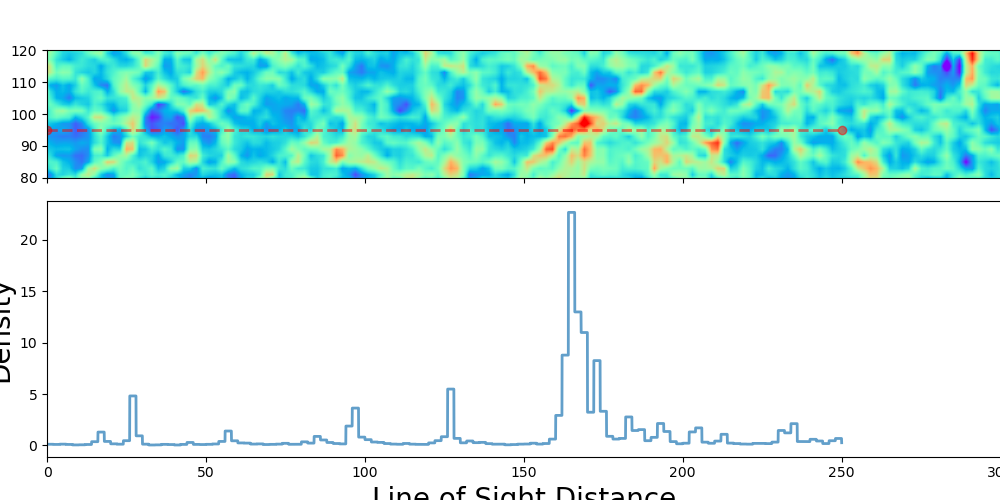

In [93]:
fig, ax = plt.subplots(nrows=2,figsize=(10,5),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = np.log(l_arr[-1][:,:,512]+1)
ax[0].imshow(s.T,vmin=-4,vmax=4,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
ax[0].plot([start_point[0], end_point[0]], [start_point[1],  end_point[1]], 'ro--',lw=2,alpha=0.5)
ax[0].set_xlim(0,300)
ax[0].set_ylim(80,120)

ax[1].plot(np.linspace(0, s1.r, len(s1.los)),los_arr[-1]+1,alpha=0.7,lw=2)

#ax[1].set_xlim(0,s1.r)
#ax[1].set_ylim(0,15)

ax[1].set_xlabel("Line of Sight Distance",fontsize=20)
ax[1].set_ylabel("Density",fontsize=20)
fig.tight_layout(pad=-1.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
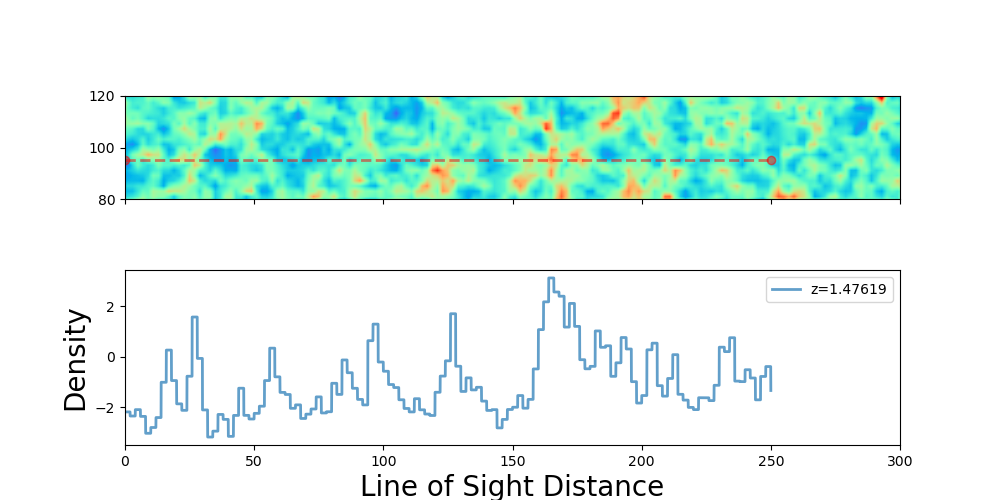

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
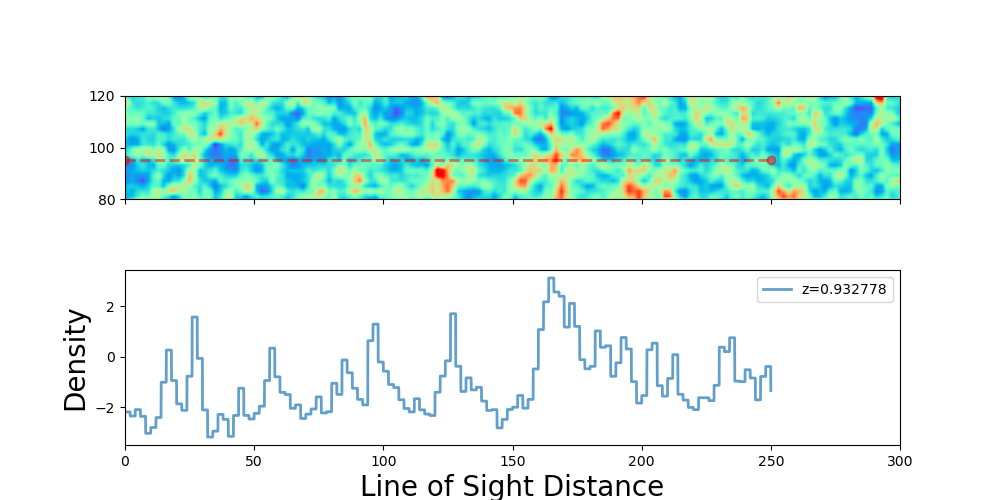

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
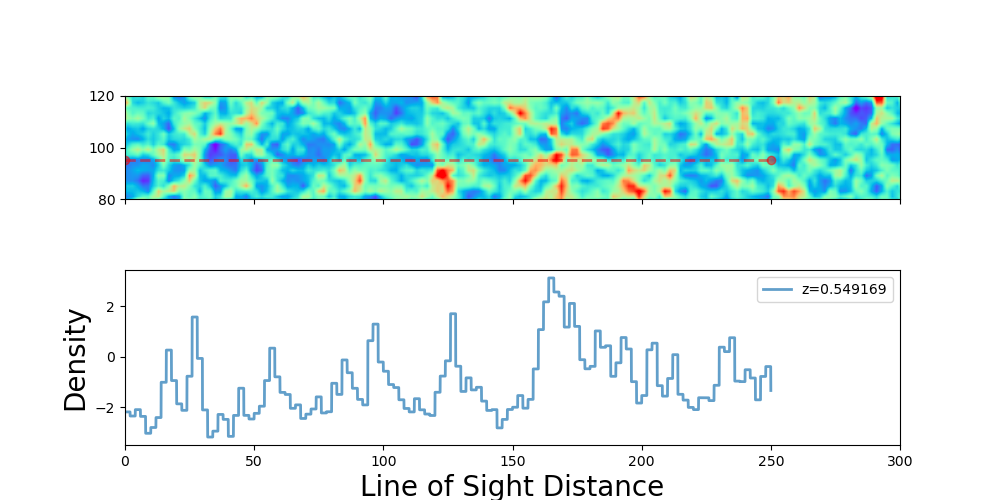

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
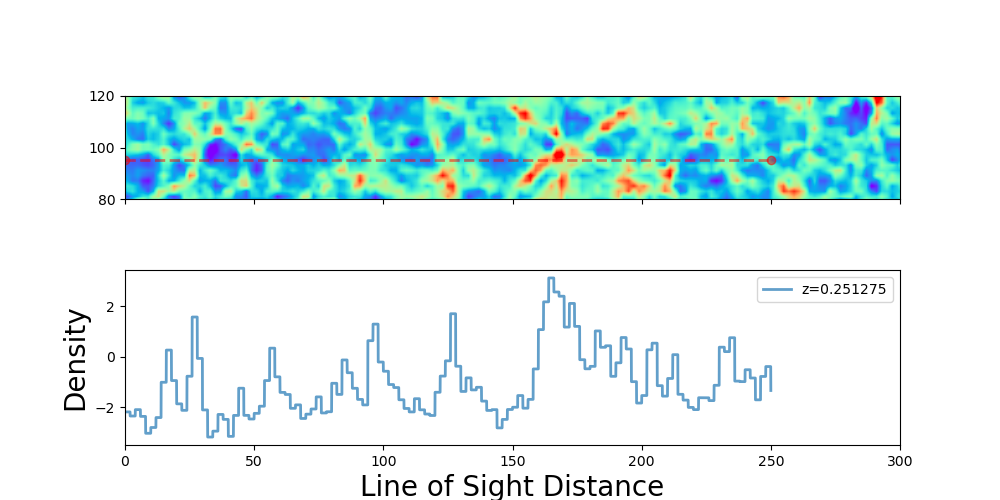

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
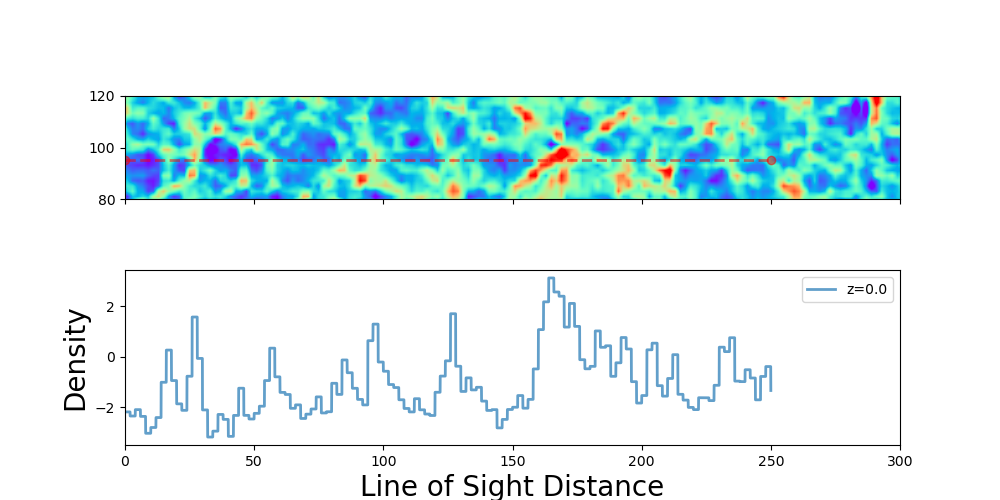

In [99]:
for i in range(len(los_arr))[::5]:
    fig, ax = plt.subplots(nrows=2,figsize=(10,5),sharex = True)    
    s = np.log(l_arr[i][:,:,512]+1)
    ax[0].imshow(s.T,vmin=-3,vmax=3,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
    ax[0].plot([start_point[0], end_point[0]], [start_point[1],  end_point[1]], 'ro--',lw=2,alpha=0.5)
    ax[0].set_xlim(0,300)
    ax[0].set_ylim(80,120)


    ax[1].plot(np.linspace(0, s1.r, len(s1.los)),np.log(los_arr[-1]+1),alpha=0.7,lw=2, label="z="+str(files["redshift"][i]))


    ax[1].set_xlabel("Line of Sight Distance",fontsize=20)
    ax[1].set_ylabel("Density",fontsize=20)
    ax[1].legend()


In [ ]:
#Solve Poisson Equation with FFT
#phi(x) = 4 pi G IFT[FT[delta/k^2]]

In [ ]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return k2.astype(np.float16)

In [ ]:
len(l_arr[0])

1024

In [ ]:
k2 = k_box(len(l_arr[0]),len(l_arr[0])*res)

In [ ]:
delta_k = np.fft.fftn(l_arr[0])

In [ ]:
delta_kk2 = delta_k /k2

<ipython-input-61-a451f862da2e>:1: RuntimeWarning: divide by zero encountered in true_divide
  delta_kk2 = delta_k /k2
<ipython-input-61-a451f862da2e>:1: RuntimeWarning: invalid value encountered in true_divide
  delta_kk2 = delta_k /k2


In [ ]:
delta_kk2[0,0,0] =  0

In [ ]:
phi_r = np.fft.ifftn(delta_kk2)

In [ ]:
phi_r = phi_r.real 

(0.0, 300.0)

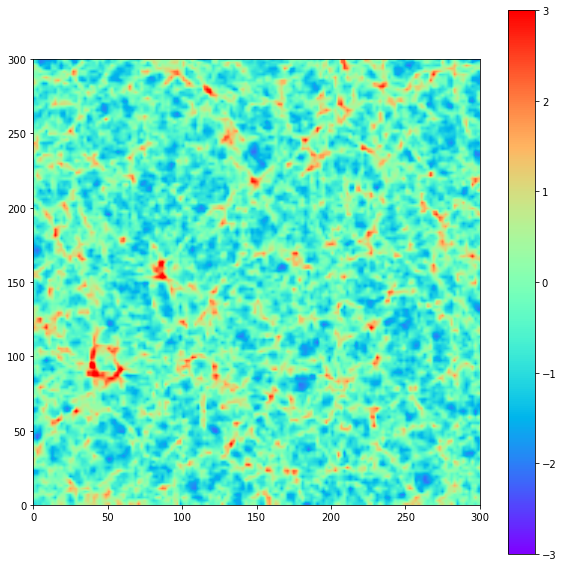

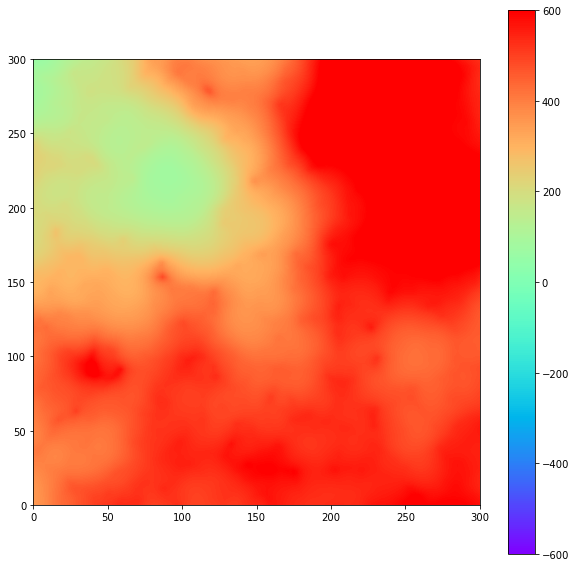

In [ ]:
plt.figure(figsize=(10,10))
s = np.log(l_arr[0][:,:,0]+1)
plt.imshow(s.T,vmin=-3,vmax=3,origin="lower",aspect="equal", interpolation="bilinear", extent=[0,2048.,0,2048],cmap="rainbow")
plt.colorbar()
plt.xlim(0,300)
plt.ylim(0,300)
s = (phi_r[:,:,0])
plt.figure(figsize=(10,10))
plt.imshow(s.T,vmin=-600,vmax=600,origin="lower",aspect="equal", interpolation="bilinear", extent=[0,2048.,0,2048],cmap="rainbow")
plt.colorbar()
plt.xlim(0,300)
plt.ylim(0,300)


(array([1.26367300e+06, 1.35243400e+07, 6.03349580e+07, 1.94259856e+08,
        3.53311156e+08, 2.81397506e+08, 1.32500703e+08, 3.40166460e+07,
        3.07715400e+06, 5.58320000e+04]),
 array([-1198.63702006,  -947.8639867 ,  -697.09095333,  -446.31791997,
         -195.5448866 ,    55.22814676,   306.00118012,   556.77421349,
          807.54724685,  1058.32028022,  1309.09331358]),
 <BarContainer object of 10 artists>)

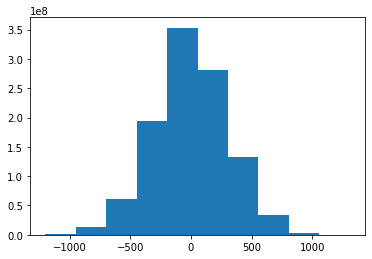

In [ ]:
plt.hist(phi_r.ravel())